In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import joblib

In [15]:
df = pd.read_csv('../CSV files/df_ufc_masters_w_reversed.csv')

In [16]:
features = [
    'r_avg_sig_str_landed',
    'r_avg_sig_str_pct',
    'r_avg_sub_att',
    'r_avg_td_landed',
    'r_avg_td_pct',
    'r_height_cms',
    'r_reach_cms', 
    'r_age',
    'b_avg_sig_str_landed',
    'b_avg_sig_str_pct',
    'b_avg_sub_att',
    'b_avg_td_landed',
    'b_avg_td_pct',
    'b_height_cms',
    'b_reach_cms', 
    'b_age']

In [17]:
#X = df[feature_names]
#y = df['Winner'].apply(lambda x: 1 if x == 'Red' else 0)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
train_end_date = '2020-09-05'
test_start_date = '2020-09-06'
df_train = df[(df['date'] <= train_end_date)]
df_test = df[(df['date'] >= test_start_date)]
X_train =df_train[features]
y_train= df_train['winner']
X_test =df_test[features]
y_test= df_test['winner']

In [19]:
y_train_encoded = y_train.apply(lambda x: 1 if x == 'Red' else 0)
y_test_encoded = y_test.apply(lambda x: 1 if x == 'Red' else 0)

In [20]:
xgb_model = xgb.XGBClassifier(n_estimators=100,
    learning_rate=0.01,
    max_depth=4,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.3,
    eval_metric='logloss',
    use_label_encoder=False)

In [21]:
xgb_model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [22]:
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

Train accuracy: 0.6289546079779917
Train precsision: 0.6278699704478291
Train recall: 0.6331957817514902


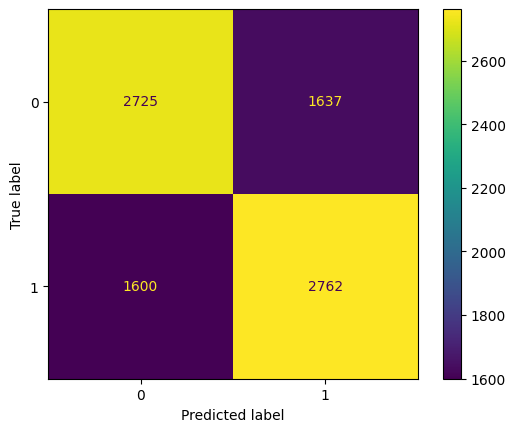

In [23]:
acc_train = accuracy_score(y_train_encoded, y_pred_train)
cm_train = confusion_matrix(y_train_encoded, y_pred_train)
ConfusionMatrixDisplay(cm_train).plot()
tn = cm_train[0,0]
fp = cm_train[0,1]
fn = cm_train[1,0]
tp = cm_train[1,1]
precision = tp/(fp+tp)
recall = tp/(tp+fn)

print(f'Train accuracy: {acc_train}')
print(f'Train precsision: {precision}')
print(f'Train recall: {recall}')

Test accuracy: 0.5936329588014981
Test precsision: 0.5936329588014981
Test recall: 0.5936329588014981


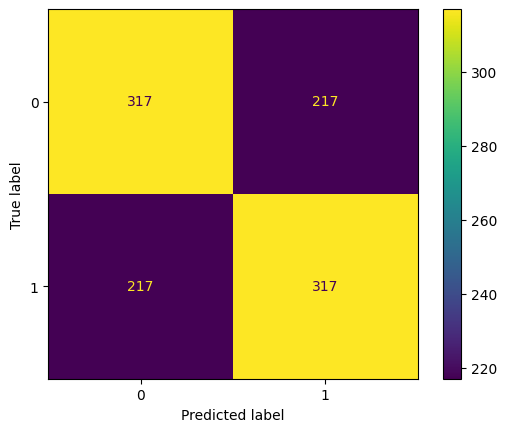

In [24]:
acc_test = accuracy_score(y_test_encoded, y_pred_test)
cm_test = confusion_matrix(y_test_encoded, y_pred_test)
ConfusionMatrixDisplay(cm_test).plot()
tn = cm_test[0,0]
fp = cm_test[0,1]
fn = cm_test[1,0]
tp = cm_test[1,1]
precision_test = tp/(fp+tp)
recall_test = tp/(tp+fn)

print(f'Test accuracy: {acc_test}')
print(f'Test precsision: {precision_test}')
print(f'Test recall: {recall_test}')

In [28]:
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']